# makemore: part 3

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../assets/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])      # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [7]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 27.8817
  10000/ 200000: 2.9683
  20000/ 200000: 2.5963
  30000/ 200000: 2.8802
  40000/ 200000: 2.0892
  50000/ 200000: 2.4638
  60000/ 200000: 2.4338
  70000/ 200000: 2.1339
  80000/ 200000: 2.3484
  90000/ 200000: 2.3672
 100000/ 200000: 2.0759
 110000/ 200000: 2.4360
 120000/ 200000: 1.9684
 130000/ 200000: 2.4576
 140000/ 200000: 2.2758
 150000/ 200000: 2.1500
 160000/ 200000: 2.1268
 170000/ 200000: 1.8041
 180000/ 200000: 1.9842
 190000/ 200000: 1.8630


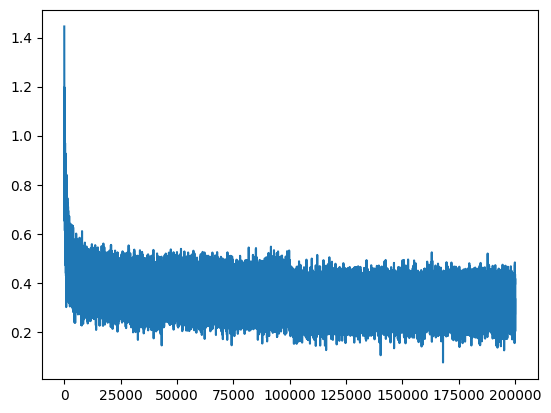

In [8]:
plt.plot(lossi)

In [9]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # contact into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1273117065429688
val 2.1735169887542725


In [10]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initial with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

mona.
mayah.
seen.
nah.
yal.
rener.
jendrari.
adeendielin.
shi.
jenne.
elissopharleiyah.
hotelin.
shubergahimies.
kendreth.
konnton.
fouden.
celeyyah.
fael.
yuma.
myshayda.


# 1. Fixing the initial loss

Our network is very improperly configured at initialization and there's multiple things wrong with it

let's just start with the first one look here in the 0th iteration we are recording a loss of 27


>      0/ 200000: 27.8817

and this rapidly comes down to roughly 1 or 2 or so, we can tell that initialization is all messed up because this is way too high

in training of neural nets it is almost always the case that you will have a rough idea for what loss to expect at initialization and that just depends on the loss function and the problem setup
and in this case i do not expect 27, i expect a much lower number and we can calculate it together

basically at initialization what we like is that there's 27 characters that could come next for any one training example, at initialization we have no reason to believe any characters to be much more likely than others and so we'd expect that the probability distribution that comes out initially is a uniform distribution assigning about equal probability to all the 27 characters

So basically what we'd like is that probability for any character would be roughly 1 over 27
> 1/27.0

that is the probability we should record and then loss is the negative log probability

> -torch.tensor(1/27.0).log()

that's the loss we would expect

which is `3.29` much much lower than `27`


In [11]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

So what's happening right now is that at the initialization the neural net is creating probability distributions that are all messed up, some characters are very confident and some characters are very not confident and then basically what's happening is that the network is very confidently wrong and that's what makes it record very high loss 

Let's say we only have four characters and then we have logits that come out of the neural net and they are very very close to 0 then we take the softmax of the all zeros we get probabilities there are a diffused distribution, so sums to one and is exactly uniform and then in this case if the label is say 2 it doesn't actually if this label is 2 or 3 or 1 or 0, because it's a uniform distribution we're recording the exact same loss in this case `1.38`

so this is the loss we would expect for a four-dimensional example now you can see ofcourse that as we start to manipulate these logits, we're going to be changing the loss

In [12]:
# 4 dimensional example of the issue
logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 0., 0.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

So it could be that we lock out and by chance `torch.tensor([0.0, 0.0, 👉0.0, 0.0])` this could be a very high number like you know 5 or something like that then in that case we'll record a very low loss because we're assigning the correct probability at initialization by chance to the correct label

In [13]:
logits = torch.tensor([0.0, 0.0, 5.0, 0.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([0., 0., 5., 0.]),
 tensor([0.0066, 0.0066, 0.9802, 0.0066]),
 tensor(0.0200))

much more likely it is that some other dimension will have a high logit and then what will happen is we start to record much higher loss

In [14]:
logits = torch.tensor([-3.0, 5.0, 0.0, 2.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-3.,  5.,  0.,  2.]),
 tensor([3.1741e-04, 9.4620e-01, 6.3754e-03, 4.7108e-02]),
 tensor(5.0553))

for example if we have `torch.randn(4)` so these are normally distributed numbers

Because these logits are near 0 for the most part the loss that comes out is okay

In [15]:
logits = torch.randn(4)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-0.5846, -1.1180,  0.1164, -0.5113]),
 tensor([0.2137, 0.1254, 0.4309, 0.2300]),
 tensor(0.8419))

But suppose `torch.randn(4)` this is * 10 now you see how because these are more extreme values it's very unlikely that you're going to be guessing the current bucket and then you're confidently wrong and recording very high loss

In [16]:
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([14.2323,  2.1770,  2.9757, -4.5793]),
 tensor([9.9998e-01, 5.8130e-06, 1.2921e-05, 6.7640e-09]),
 tensor(11.2566))

if your logits are coming out even more extreme you might get extremely insane losses like infinity ♾️ even at initialization

In [17]:
logits = torch.randn(4) * 100
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-49.8762,  86.2306, -22.9039,  80.3888]),
 tensor([0.0000, 0.9971, 0.0000, 0.0029]),
 tensor(inf))

So basically this is not good and we want the logits to be roughly 0 when the network is initialized
in fact the logits can don't have to be just 0 they just have to be equal

so, for example if all the logits are 1 because of the normalization inside the softmax this will actually come out okay.

In [18]:
logits = torch.tensor([1.0, 1.0, 1.0, 1.0])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([1., 1., 1., 1.]),
 tensor([0.2500, 0.2500, 0.2500, 0.2500]),
 tensor(1.3863))

but by symmetry we don't want it to be any arbitrary positive or negative number we just want it to be all zeros and record the loss that we expect at initialization

So let's now concretely see where things go wrong in our example

In [19]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g)
b2 = torch.randn(vocab_size,                       generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [20]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 27.8817


In [21]:
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [22]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.1
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [23]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 4.2326


In [24]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


now you're probably wondering can we just set this to zero, then we get ofcourse exactly what we're looking for at initialization and the reason i don't usually do this is bacause i'm very nervous and i'll show in a second why you don't want to be setting W's or weights of a neural nets exactly to 0, you usually want it to be small numbers instead of exactly 0, for this output layer in this specifi case i think it would be fine, but i'll show you in a second where things go wrong very quicky if you do that

In [26]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [27]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.2958


let's just go with `0.01`, in that case our loss is close enough but has some entropy it's not exactly zero it's got some entropy and that's used for symmetry breaking as we'll see in a second.

In [28]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [29]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


In [30]:
logits[0]

tensor([-0.0249,  0.3523, -0.1267,  0.0541,  0.1662, -0.1171, -0.0140,  0.0124,
         0.0921,  0.1135,  0.1362, -0.0925,  0.0444, -0.2459, -0.0971,  0.0125,
        -0.0957, -0.1376, -0.2329, -0.0137,  0.2452,  0.1616,  0.1665, -0.1094,
        -0.2154,  0.0725,  0.1141], grad_fn=<SelectBackward0>)

logits are now coming out much closer to zero and everything is well and good

i now take away the `break` statement we can run the optimization with this new initialization and let's just see what losses we record

In [31]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [32]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


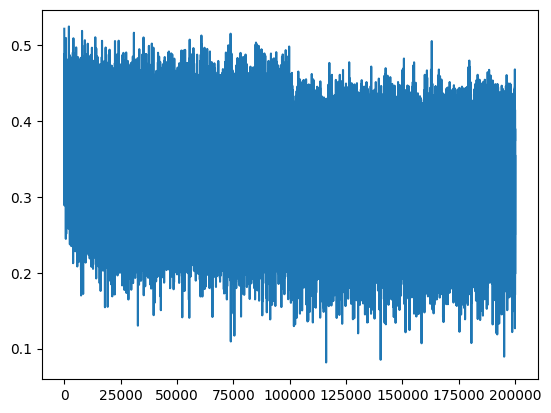

In [33]:
plt.plot(lossi)

the plot of the loss now doesn't have this hockey shape appearance, because basically what's happening in the hockey stick the very first few iterations of the loss what's happening during the optimization is the optimization is just squashing down the logits and then it's rearranging the logits

so basically we took away this easy part of the loss function where just the weights were just being shrunk down and so therefore we don't get these easy gains in the beginning and we're just getting the hard gains of training the actual neural net and so there's no hockey stick appearance

so good things are happening in that both

1. loss at initialization is what we expect and the loss doesn't look like a hockey stick and this is true for any neural network you might train

In [34]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # contact into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.069589138031006
val 2.1310746669769287


2. The loss that came out is actually quite a bit improved

the reason for that is because we're spending more cycles more time optimizing the neural net actually instead od just spending the first several thousand iterations probably just squashing down the weights because they are so way too high in the begining in the initialization

# 2. Fixing the saturated tanh

now let's look at the second problem let me reinitialize our neural net and let me reintroduce the break statement

In [35]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                         generator=g)
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [36]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3221


So we have a resonable initial loss, so even though everything is looking good on the level of the loss and we get something that we expect there's still a deeper problem looking inside this neural net and it's initialization so the logits are now okay the problem now is with the values of `h` the activations of the hidden states

In [37]:
h

tensor([[ 0.8100, -0.8997, -0.9993,  ..., -0.9097, -1.0000,  1.0000],
        [-1.0000, -0.9571, -0.7145,  ...,  0.4898,  0.9090,  0.9937],
        [ 0.9983, -0.3340,  1.0000,  ...,  0.9443,  0.9905,  1.0000],
        ...,
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000],
        [-1.0000, -0.4385, -0.8882,  ..., -0.3316,  0.9995,  1.0000],
        [-1.0000,  0.9604, -0.1418,  ..., -0.1266,  1.0000,  1.0000]],
       grad_fn=<TanhBackward0>)

Now if we just visualize this tensor `h` it's kind of hard to see but the problem here roughly speaking is you see how many elements are `1` or `-1`

now recall that `torch.tanh` the `tanh` function is a squashing function, it takes arbitrary and it squashes them into a range of `-1` and `1` and it does so smoothly

so let's look at the histogram of `h` to get a better idea of the distribution of the values inside this tensor

In [38]:
h.shape

torch.Size([32, 200])

In [39]:
h.view(-1).shape

torch.Size([6400])

In [40]:
h.view(-1).tolist()

[0.8100222945213318,
 -0.8996702432632446,
 -0.999309241771698,
 0.9980825185775757,
 -0.6508485078811646,
 -0.6897533535957336,
 -0.9619210362434387,
 -0.9999876022338867,
 -0.3420684039592743,
 0.999920666217804,
 0.9999915957450867,
 -0.9980642199516296,
 0.9876819252967834,
 0.8998496532440186,
 0.8862370252609253,
 0.7360541820526123,
 -0.9959285855293274,
 -0.981837809085846,
 -0.989227294921875,
 0.9997955560684204,
 -0.9220333695411682,
 -0.8541557192802429,
 0.0639711245894432,
 0.9999996423721313,
 0.9979971051216125,
 -0.9949458837509155,
 0.9996280670166016,
 -0.9998515844345093,
 0.6444535255432129,
 0.7554441690444946,
 -0.9997296929359436,
 0.9996114373207092,
 0.9912618398666382,
 0.9449755549430847,
 0.9999983310699463,
 -0.9999998211860657,
 0.9999754428863525,
 -0.9999991059303284,
 1.0,
 -0.5565183758735657,
 0.9787917137145996,
 -0.9885085225105286,
 0.9983248710632324,
 -0.9999771118164062,
 -0.03651892766356468,
 0.9999677538871765,
 0.9990684986114502,
 -0.72501

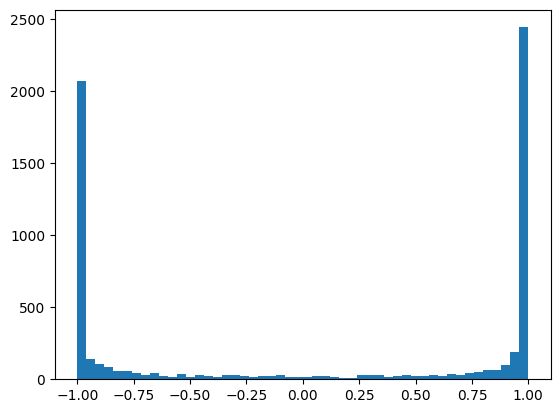

In [41]:
plt.hist(h.view(-1).tolist(), bins=50);

so we see this histogram and we see that most the values by far take on value of `-1` and `1` so this `tanh` is very very active and we can also look at why that is at basically why that is we can look at the pre activations that feed into the `tanh`

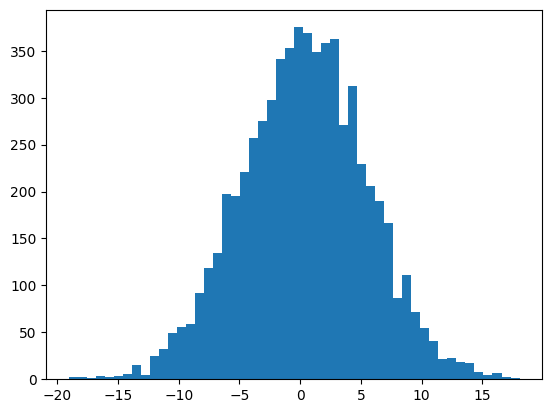

In [42]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

we can see that the pre activations are is very very broad these numbers take numbers between `-15` and `15` and that's why in a `torch.tanh` everything is being squashed and capped to be in the range of `-1` and `1` and lot of numbers here take on very extreme values.

If you are new to neural networks you might not actually see this an issue, but if you'r Well-versed in the dark arts of back propagation and then having an intuitive sense of how these gradients flow through a neural network 🙌

you are looking at your distribution of `tanh` activations here and you are sweating 🥵
so let me show you why, we have to keep in mind that during back propagation just like we saw in micrograd we are doing backward pass starting at the loss and flowing through the network backwards in particular we're going to back propagate through `torch.tanh`

`h = torch.tanh(hpreact)` this layer is made up of `200` neurons for each one of these examples and it implements an elementwise `tanh`

So let's look at happens in `tanh` in the backward pass

```python
def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
        x = self.grad += (1 - t**2) * out.grad
    out._backward = _backward
```
we saw that the input here was `x` and then we calculate `t` which is `tanh(x)` so that's `t`, and the `t` is between `-1` and `1` it's the output of the `tanh` and then in the backward pass how do we backpropagate through a `tanh`, we take `out.grad` and then we multiply it this is the chain rule with the local gradient which took the form of `1 - t^2`, so what happens if the outputs if your `tanh` are very close to `-1` or `1`, if you plug in `t=1` here: 
```python
(1 - t**2) * out.grad 
```
you are going to get a 0, multiplying `out.grad`, no matter what `out.grad` is we are killing the gradient and we're stopping effectively the back propagation through this tanh unit, similarly when `t=-1`, this will again become zero and out.grad just stops and intuitively this makes sense because what's happening is if it's output is very close to one then we're in the tail of this tanh and so changing basically the input is not going to impact the output of the tanh too much because it's in a flat region of the tanh and so therefore there's no impact on the loss

so indeed the weights and the biases along with the tanh neuron do not impact the loss because the output of tanh do not impact the loss because the output of the tanh unit is in the flat region of the tanh and there's no influence we can be changing then whatever we want, however we want and the loss is not impacted that's an another way to justify that indeed the gradient would be basically 0, it vanishes. When `t=0` we get `1 * out.grad` when tanh takes on exactly value of `0` then `out.grad` is just passed through it

basically what this is doing right is if `t=0` and then this tanh unit is sort of inactive and gradient just passes through it, but the more you are in the flat tails the more the gradient is squashed so infact you'll see that the gradient flowing through tanh can only ever decrease and the amount that it decreases is proportional through a ^2 here depending on how far you are in a flat tail of this tanh and so that's kind of what's happening here and through this the concern here is that if all of these outputs `h` are flat regions of `-1` and `1` then the gradients that are flowing through the network will get destroyed at this layer

> now there is some redeeming quality here and that we can actually get a sense of the problem as follows

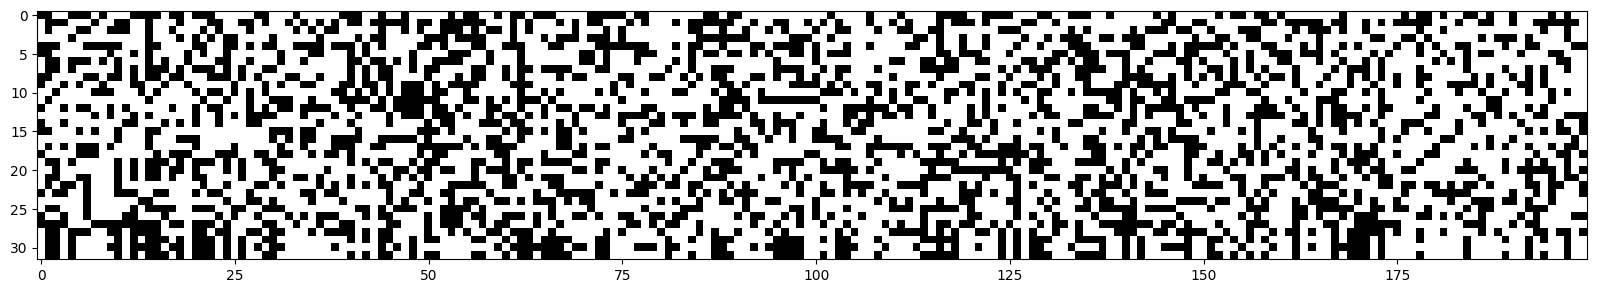

In [43]:
plt.figure(figsize=(20, 20))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Basically this is a boolean tensor `h.abs() > 0.99` you get `white` if this is `true` and a `black` if this is `false` and basically what we have here is the 32 examples and 200 hidden neurons and we see that a lot of this is `white` and that's telling us is that all these tanh neurons were very very active and they are in a flat tail and so in all these cases the backward gradient would get destroyed

now we would be in a lot of trouble if for any one of these 200 neurons if it was the case that the entire column is white because in that case we have what's called a `dead neuron` and this could be a tanh neuron where the initialization of the weights and biases could be such that no single example ever activates this tanh in the sort of active part of the tanh if all the examples land in the tail then this neuron will never learn it is a dead neuron.

> So therefore it is the case that for every one of these tanh neurons we do have some examples that activate them in the active part of the tanh and so some gradients will flow through and this neuron will learn and the neuron will change and it will move and it will do something

> but you can sometimes get yourself in cases where you have dead neurons and the way this manifests is that for tanh neuron this would be when no matter what inputs you plug in from your dataset this tanh neuron always fires completely `1` or completely `-1` and then it will just not learn because all the gradients will be just zeroed out

* This is not just for `tanh` nut for lot of other nonlinearities that people use in neural networks
* So we certainly used tanh a lot, but sigmoid will have the exact same issue because it is a squashing neuron, same also applies to ReLU

<img src='../assets/activation_functions.webp'>

Because there i no column of white i think we will be okay and indeed the network optimizes and gives us a pretty decent loss but it's just not optimal and this is not something you want especially during initialization and so basically what's happening is that the `hpreact` it's too extreme it's too large it's creating a distribution that is too saturated in both sided of the tanh and it's not something you want because it means that there's less training for these neurons because they update less frequently

so how do we fix this well `hpreact` is `embcat` which comes from `C` so these are uniform Gaussian but then it's multiply by `W1 + b1` and `hpreact` us far off from zero and that's causing the issue so we wanr this `preact` to be closer to 0.

In [44]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.1
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [45]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3069


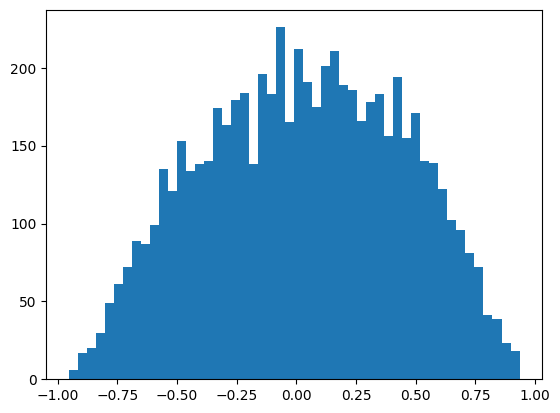

In [46]:
plt.hist(h.view(-1).tolist(), bins=50);

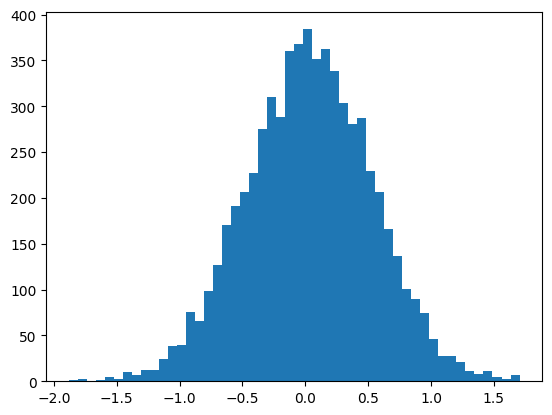

In [47]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

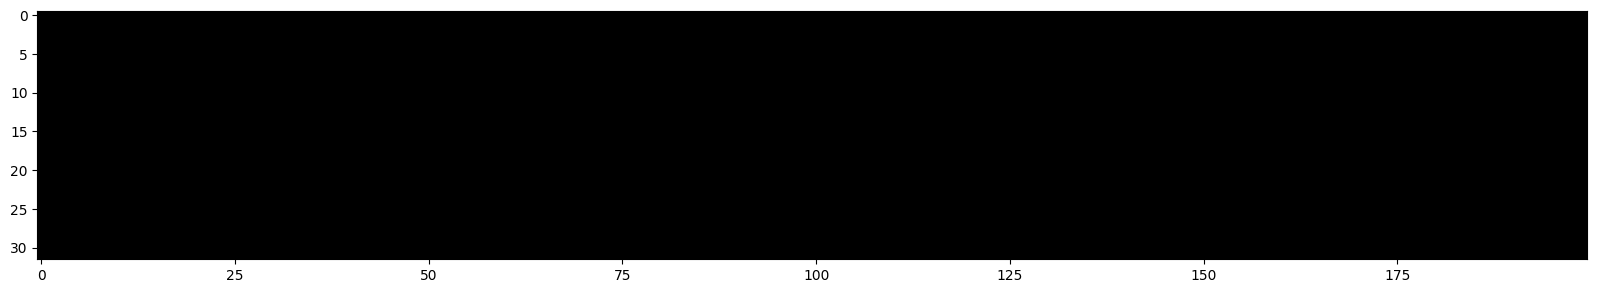

In [48]:
plt.figure(figsize=(20, 20))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [49]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [50]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    break

      0/ 200000: 3.3135


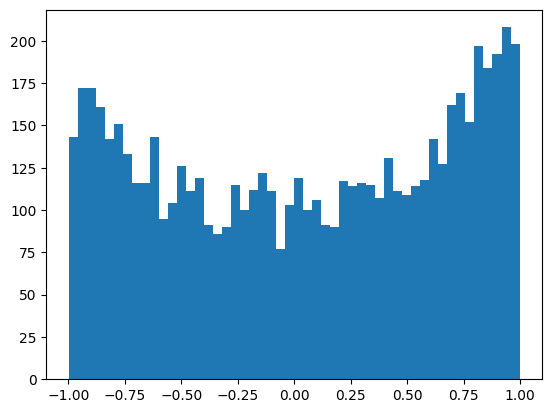

In [51]:
plt.hist(h.view(-1).tolist(), bins=50);

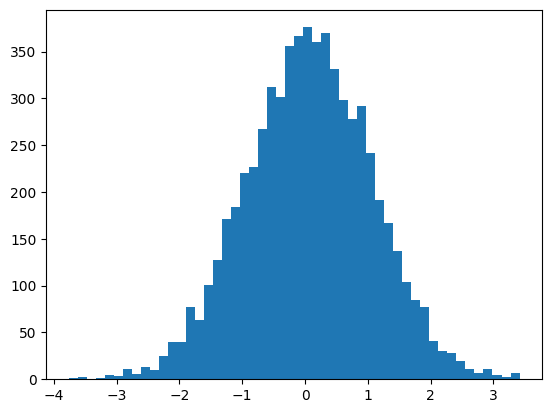

In [52]:
plt.hist(hpreact.view(-1).tolist(), bins=50);

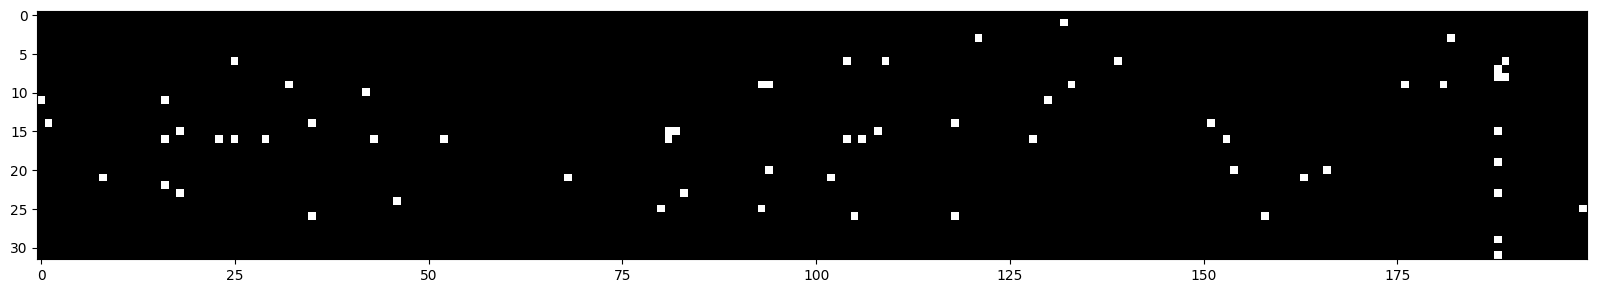

In [53]:
plt.figure(figsize=(20, 20))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [57]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [58]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


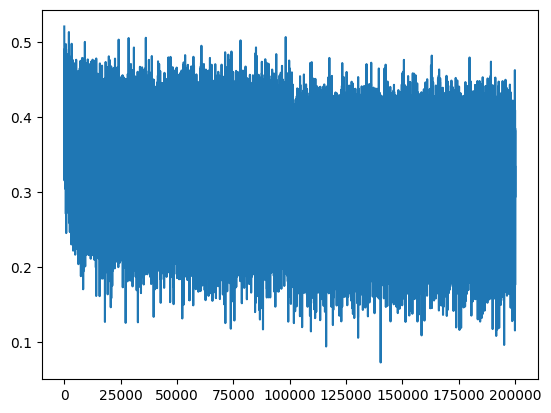

In [59]:
plt.plot(lossi)

In [60]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # contact into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


```python
# loss log

# original:
train 2.1245384216308594
val     2.16819643974342

# fix softmax confidently wrong:
train 2.07
val 2.13

# fix tanh layer too saturated at init:
train 2.0355966091156006
val 2.1026785373687744
```

tensor(-0.0022) tensor(0.9964)
tensor(-0.0055) tensor(3.1860)


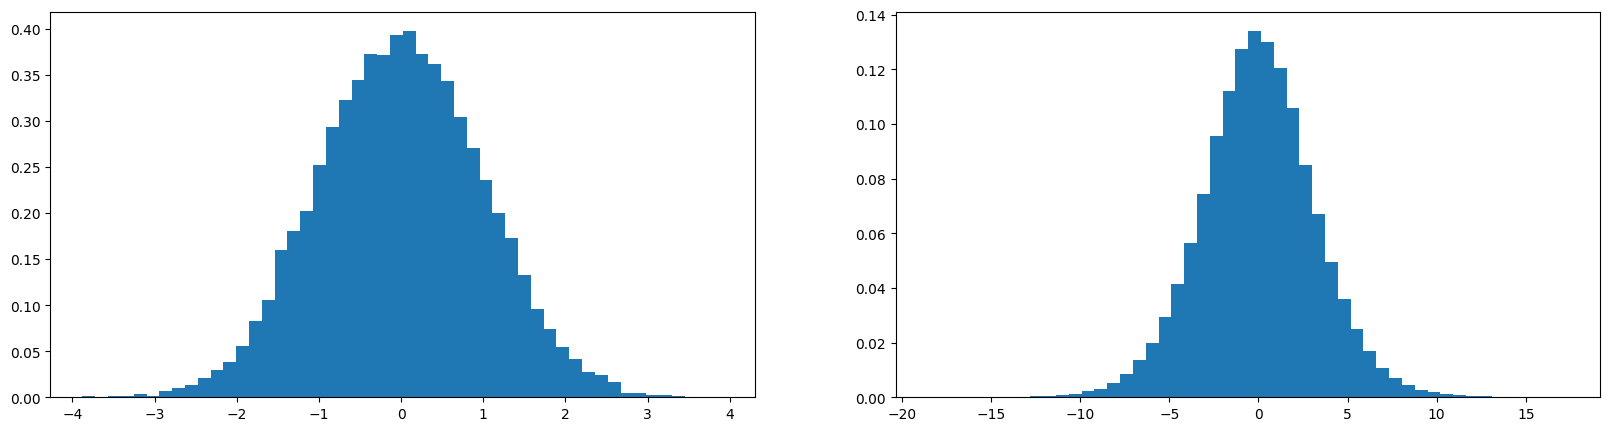

In [70]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

tensor(0.0044) tensor(1.0014)
tensor(-0.0253) tensor(15.8286)


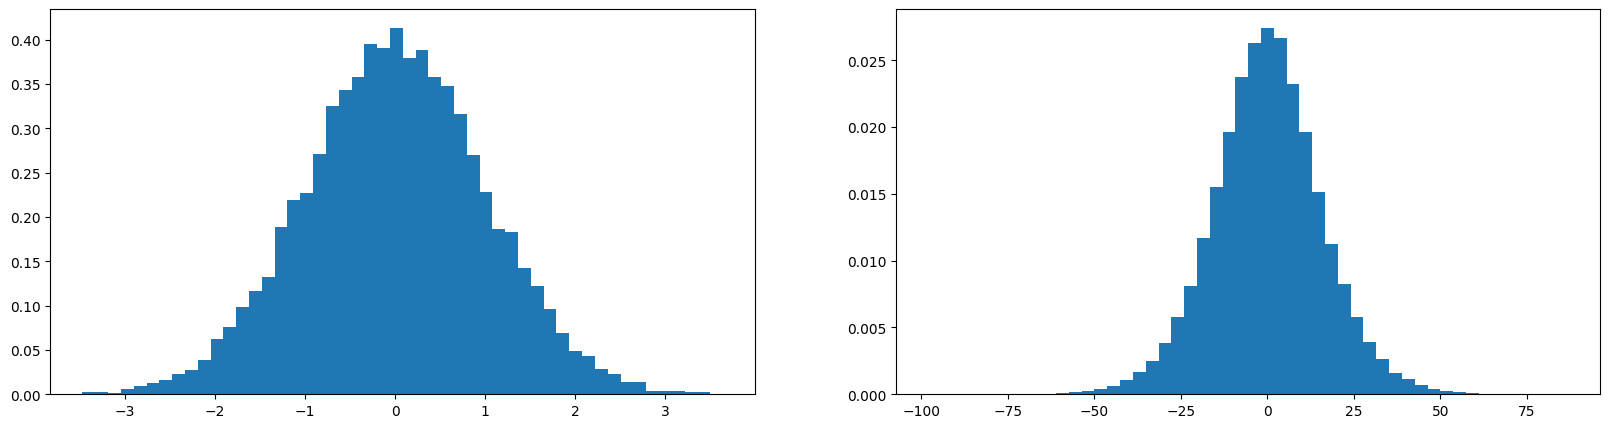

In [71]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

tensor(-0.0115) tensor(0.9880)
tensor(-0.0001) tensor(0.6206)


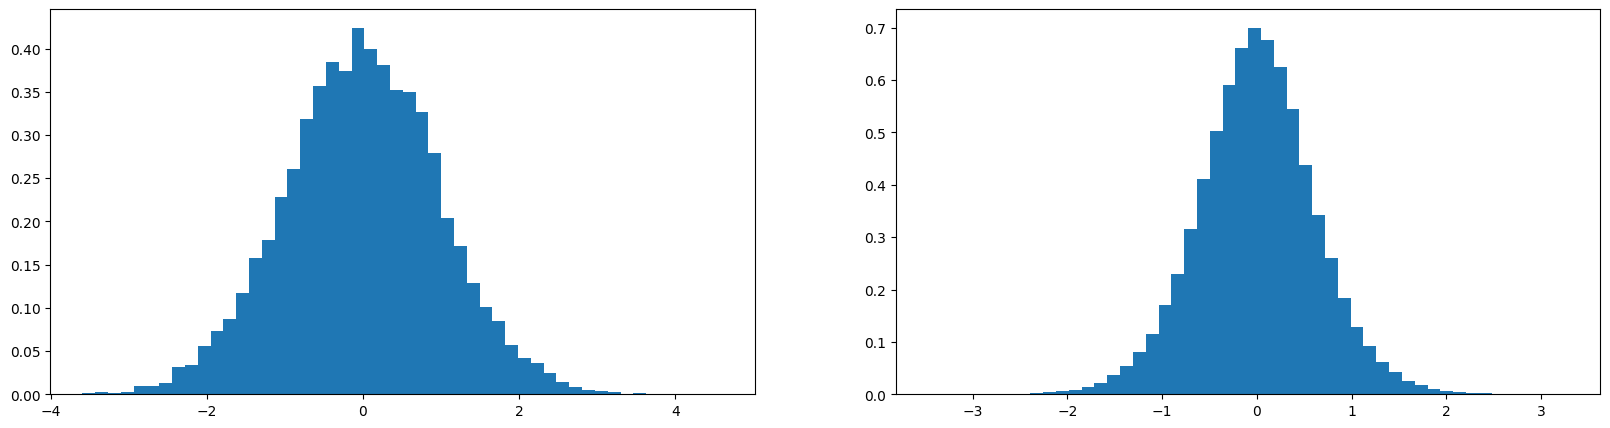

In [72]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) * 0.2
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

you are supposed to divide by the square root of `fan-in` that means the number of inputs coming in, here 10 

tensor(0.0058) tensor(1.0062)
tensor(-0.0010) tensor(1.0009)


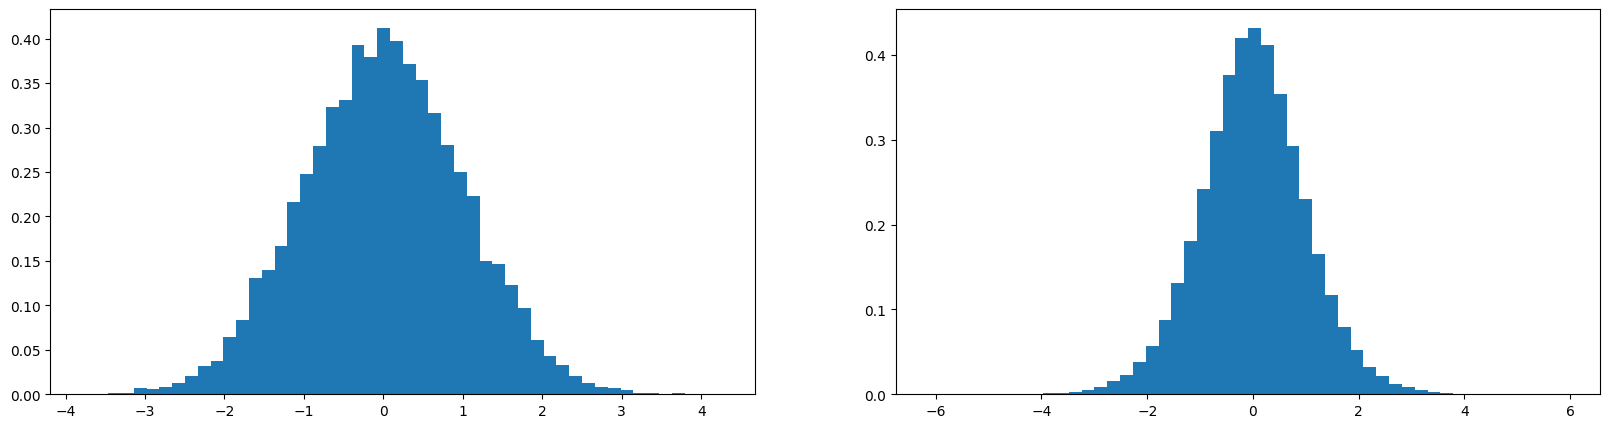

In [73]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), bins=50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), bins=50, density=True);

for more details check this out: https://docs.pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_

In [75]:
torch.randn(1000).std()

tensor(1.0088)

In [78]:
torch.randn(10000).std()

tensor(1.0138)

In [81]:
(torch.randn(10000) * 0.2).std()

tensor(0.2014)

the number we are multiplying here ends up being the standard deviation of this gaussian

for tanh, the gain is `5/3` you can see that in the docs, you can also check the value by doing this:
```python
torch.nn.init.calculate_gain(nonlinearity='tanh')
```

$$
\mathrm{std} = \frac{\mathrm{gain}}{\sqrt{\mathrm{fan\_mode}}}
$$


for our network fan_in is `n_embed * block_size`

In [90]:
n_embed * block_size

30

In [91]:
(5/3) / (30**0.5)

0.3042903097250923

In [92]:
# MLP revisited
n_embed = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility 
C = torch.randn((vocab_size, n_embed),             generator=g)
W1 = torch.randn((n_embed * block_size, n_hidden), generator=g) * (5/3)/((n_embed * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                         generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                       generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

11897


In [93]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every one in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


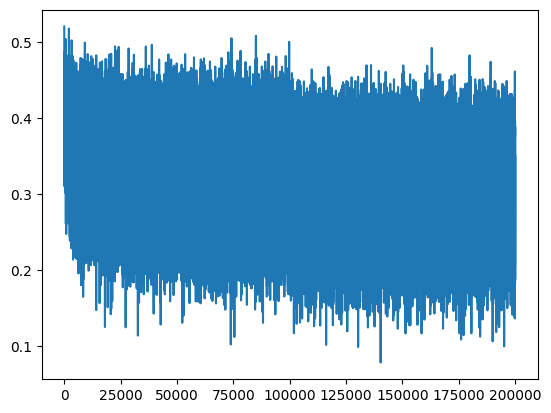

In [94]:
plt.plot(lossi)

In [95]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embed)
    embcat = emb.view(emb.shape[0], -1) # contact into (N, block_size * n_embed)
    h = torch.tanh(embcat @ W1 + b1) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


we get to the same spot, but we did not have to introduce any magic numbers, that we got from just looking at histograms and guessing, we have something that is semi-principled and will scale us to much bigger networks and something that we can sort of use as a guide